<a href="https://colab.research.google.com/github/MatheusRocha0/Churn-Prediction/blob/main/Churn-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Project: Churn Prevention Using Machine Learning
 
## Fictional Context 
 
**Disclaimer**: the context I am going to present here is not real. The company and the CEO only exist on my mind.
 
Tele Coastal is a company that offers telecom services. But recently many customers stopped buying from the company and it must be solved.
 
The CEO hired me as Data Science Consultant to propose a solution for this problem. As I know how data can help companies solving their problems I suggested a data solution based in Data Analysis and Machine Learning.
 
I would analyze the customers database to find out what to do when a churn is detected by a Machine Learning model that would be deployed and is able to predict churn.
 
After the CEO liked my idea and gave me access to the company's database, I could start working in the project.

# 0.0 Preparation

## 0.1 Installs

In [ ]:
pip install scikit-optimize -q

     |████████████████████████████████| 102kB 11.1MB/s 


## 0.2 Imports

Packages I will use in this project

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import pickle
 
import warnings
 
from imblearn.over_sampling import RandomOverSampler
 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
 
from lightgbm import LGBMClassifier
 
from skopt import gp_minimize

In [ ]:
%matplotlib inline
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

## 0.3 Loading data

In [ ]:
df = pd.read_csv("https://github.com/MatheusRocha0/Churn-Prediction-Using-ML/raw/main/telecom_churn.csv")
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


## 0.4 Helper Functions
 
An exclusive section for the functions I create to have a better code.

In [ ]:
# insert values into bar charts
def addlabels(x, y):
   for i in range(len(y)):
      plt.text(i, y[i]//2, y[i], ha = "center", color = "white", fontsize = 20)
 
# perform cross-validation
def cross_val(algo):
 
   global kf, new_x, new_y
 
   scores = []
 
   for train_idx, test_idx in kf.split(new_x, new_y):
      trainX, trainY = new_x[train_idx], new_y[train_idx]
      testX, testY = new_x[test_idx], new_y[test_idx]
  
      algo.fit(trainX, trainY)
      p = algo.predict_proba(testX)[:,1]
 
      score = roc_auc_score(y_true = testY, y_score = p)
      scores.append(score)
 
   print("Mean: ", np.mean(scores))
   
   plt.figure(figsize = (20, 15))
   ax = plt.subplot()
   ax.plot(scores)
   plt.grid(False, axis = "x")
   plt.show()
   return None
 
# for hyperparameters tuning
def train_model(params):
 
   min_samples_split = params[0]
   max_depth = params[1]
   min_samples_leaf = params[2]
 
   print(params, "\n")
 
   rf = RandomForestClassifier(
random_state = 1,
n_jobs = -1,
n_estimators = 100,
min_samples_leaf = min_samples_leaf,
max_depth = max_depth,
min_samples_split = min_samples_split
)
   rf.fit(trainX, trainY)
 
   p = rf.predict_proba(testX)[:,1]
   roc_auc = roc_auc_score(y_true = testY, y_score = p)
 
   return -roc_auc
 
# features' importances plot
def features_importances(model, cols):
   plt.figure(figsize = (15, 15))
   pd.Series(model.feature_importances_, index = cols).sort_values().plot.barh()
   return None
 
def cycle(to_drop = ["Churn"]):
 
   global df
   data = df.copy()
 
  
   data = data[(data["Churn"] == 0.0) | (data["Churn"] == 1.0)]
 
   x_ = data.drop(to_drop, axis = 1).copy()
   y_ = data["Churn"].copy()
 
   normalizer = MinMaxScaler()
   norm_x_ = normalizer.fit_transform(x_)
 
   sampler = RandomOverSampler(random_state = 1)
   new_x_, new_y_ = sampler.fit_resample(norm_x_, y_)
 
   model = RandomForestClassifier(random_state = 1)
   model.fit(new_x_, new_y_)
   pd.Series(model.feature_importances_, index = x_.columns).sort_values().plot.barh()
   cross_val(model)
   return model

# 1.0 Data Cleaning
 
In almost all cases the dataset is dirty and it is necessary to clean things like: missing values, duplicates, outliers and etc.

## 1.1 Treating missing values

In [ ]:
print("How many missing values for each variable?")
print("Variable | Missing values")
print(df.isnull().sum())

How many missing values for each variable?
Variable | Missing values
Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64


## 1.2 Treating duplicates

In [ ]:
# dropping them
df.drop_duplicates(inplace = True)

## 1.3 Treating outliers
 
There many methods to detect outliers in a dataset, but I will use the boxplot that shows outliers as black points out of box.
 
But I will exclude binary variables since there is no the possibility of outliers in this kind of variable.

It is also important to know that there are 2 types of outliers: natural and artificial outliers.

We should not exclude natural outliers for analysis, but we should exclude artificial ones for both analysis and machine learning.

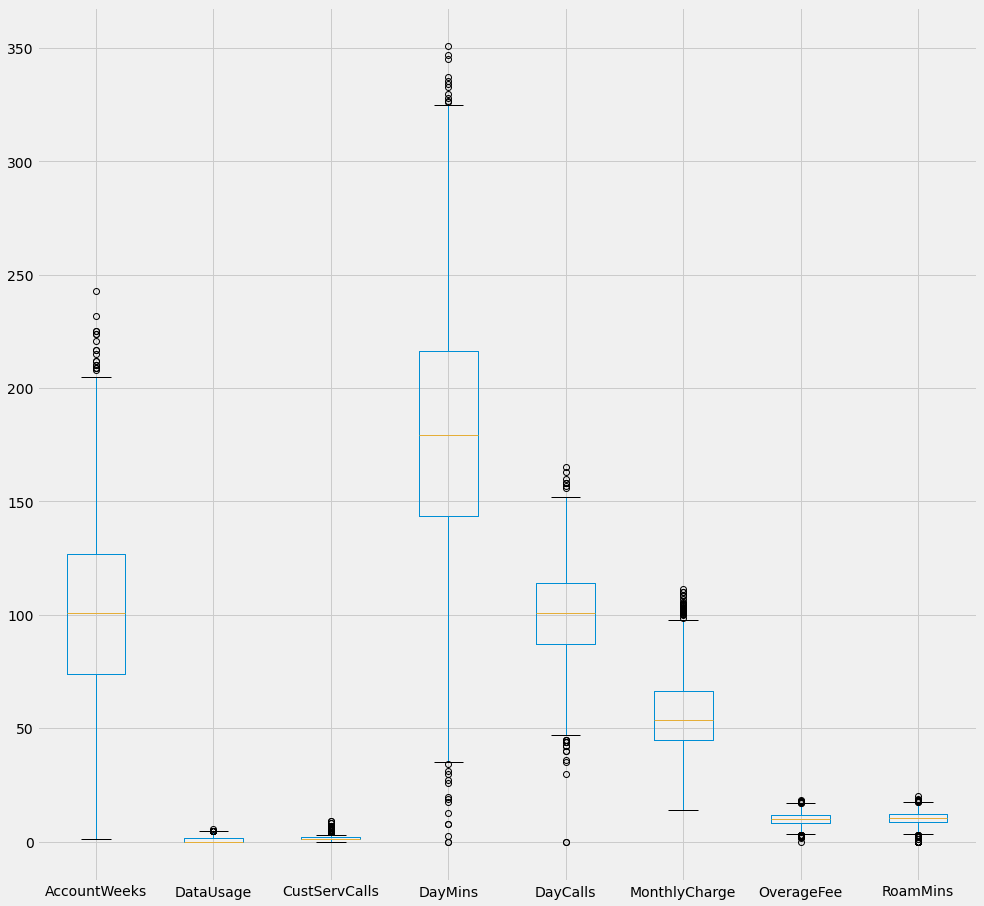

In [ ]:
plt.figure(figsize = (15, 15))
df.drop(["Churn", "ContractRenewal", "DataPlan"], axis = 1).boxplot()
plt.show()

Probably, all these outliers are natural, so we do not need to exclude them.

# 2.0 Data Analysis
 
It is now time to analyze the dataset. My main goal here is to find out what to do to when we detect a churn and try to avoid it from happening. It will be clear after.

## 2.1 Initial Analysis

An initial analysis to know more about the dataset before dive into questions and hyphotesis about the customers.

### 2.1.1 Statistics
 
This kind of statistics helps us to understand more about the customers' behaviour.
 
What intrigued me the most is the fact that 50% of the customers has a DataUsage value of 0.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Churn,3333.0,0.144914,0.352067,0.0,0.00,0.00,0.00,1.00
AccountWeeks,3333.0,101.064806,39.822106,1.0,74.00,101.00,127.00,243.00
ContractRenewal,3333.0,0.903090,0.295879,0.0,1.00,1.00,1.00,1.00
DataPlan,3333.0,0.276628,0.447398,0.0,0.00,0.00,1.00,1.00
DataUsage,3333.0,0.816475,1.272668,0.0,0.00,0.00,1.78,5.40
CustServCalls,3333.0,1.562856,1.315491,0.0,1.00,1.00,2.00,9.00
DayMins,3333.0,179.775098,54.467389,0.0,143.70,179.40,216.40,350.80
DayCalls,3333.0,100.435644,20.069084,0.0,87.00,101.00,114.00,165.00
MonthlyCharge,3333.0,56.305161,16.426032,14.0,45.00,53.50,66.20,111.30
OverageFee,3333.0,10.051488,2.535712,0.0,8.33,10.07,11.77,18.19


### 2.1.2 Dataset dimensions

In [ ]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  3333
Number of columns:  11


### 2.1.3 Histograms
 
Most of non-binary variables have a distribution similar to a Normal Distribution.

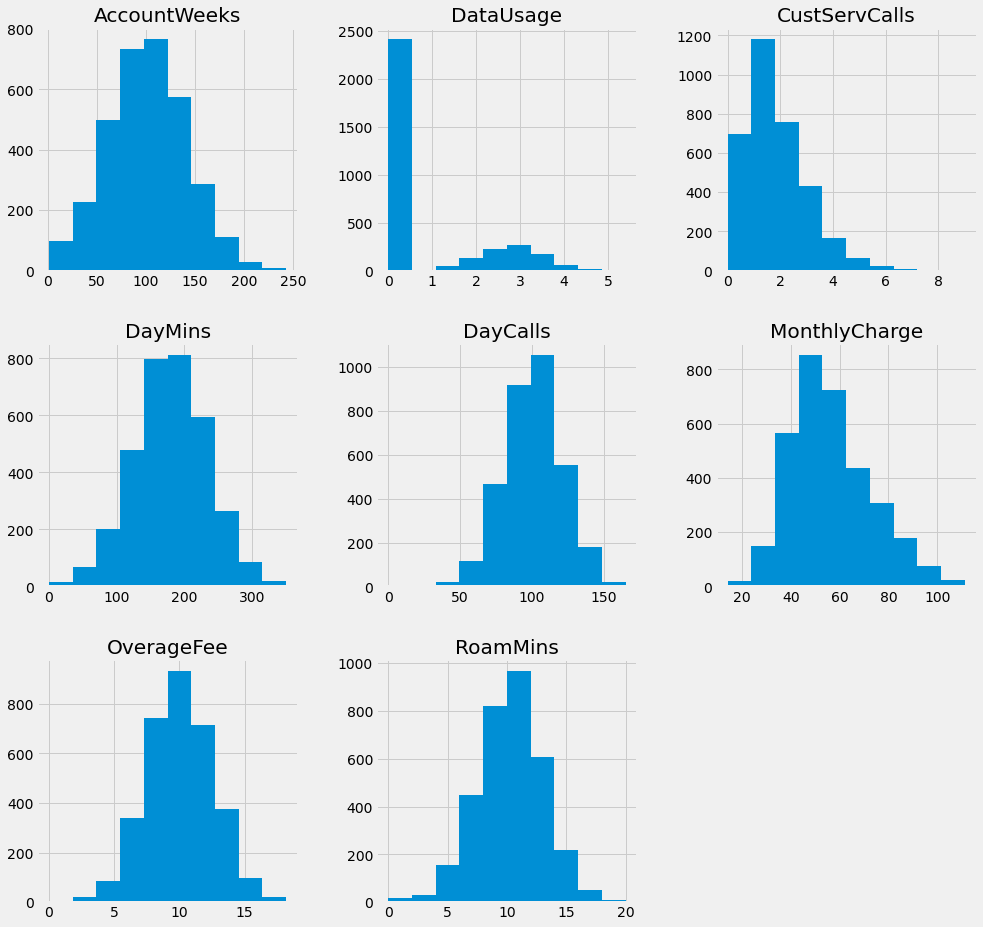

In [ ]:
df.drop(["Churn", "ContractRenewal", "DataPlan"], axis = 1).hist(figsize = (15, 15))
plt.show()

### 2.1.4 Data Types
 
What is the type of each variable?
 
There is not any wrong type here.

In [ ]:
df.dtypes

Churn                int64
AccountWeeks         int64
ContractRenewal      int64
DataPlan             int64
DataUsage          float64
CustServCalls        int64
DayMins            float64
DayCalls             int64
MonthlyCharge      float64
OverageFee         float64
RoamMins           float64
dtype: object

### 2.1.5 What is the Churn Distribution?

There are more people who are still buying from the company than churns, what is such a good thing.

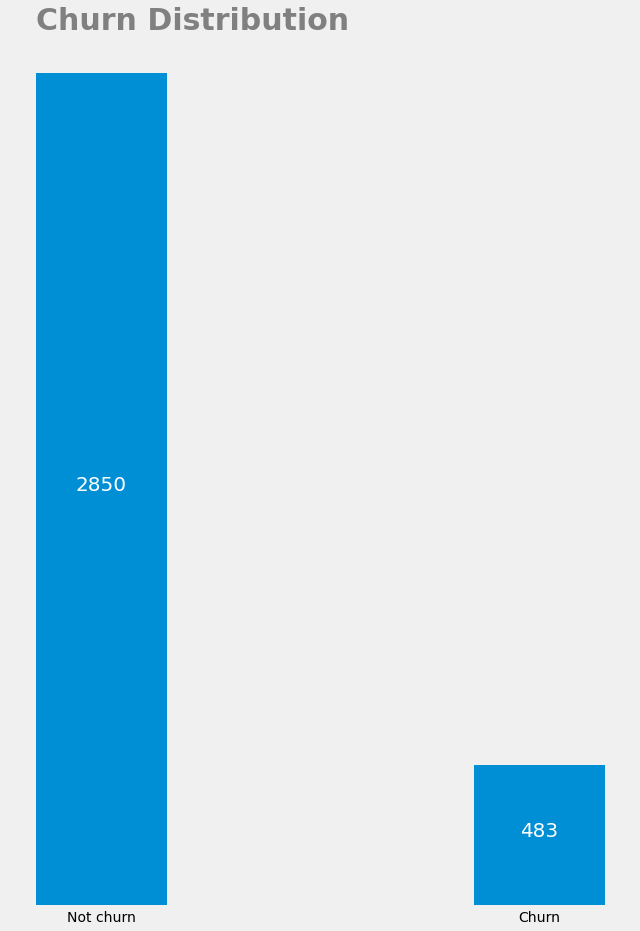

In [ ]:
not_churn = len(df[df["Churn"] == 0])
churn = len(df[df["Churn"] == 1])
labels = ["Not churn", "Churn"]
values = [not_churn, churn]
 
plt.figure(figsize = (10, 15))
ax = plt.subplot(111)
ax.bar(x = labels, height = values, width = .3)
plt.grid(False)
plt.text(s = "Churn Distribution", x = -.15, y = 3000, weight = "bold", color = "gray", fontsize = 30)
plt.gca().get_yaxis().set_visible(False)
addlabels(labels, values)
plt.show()

### 2.1.6 What is the correlation among the variables
 
The darker the stronger is the correlation between the variables.

It is possible to see that MonthlyCharge is strong correlated to the OverageFee, DayMins, DataPlan and DataUsage.

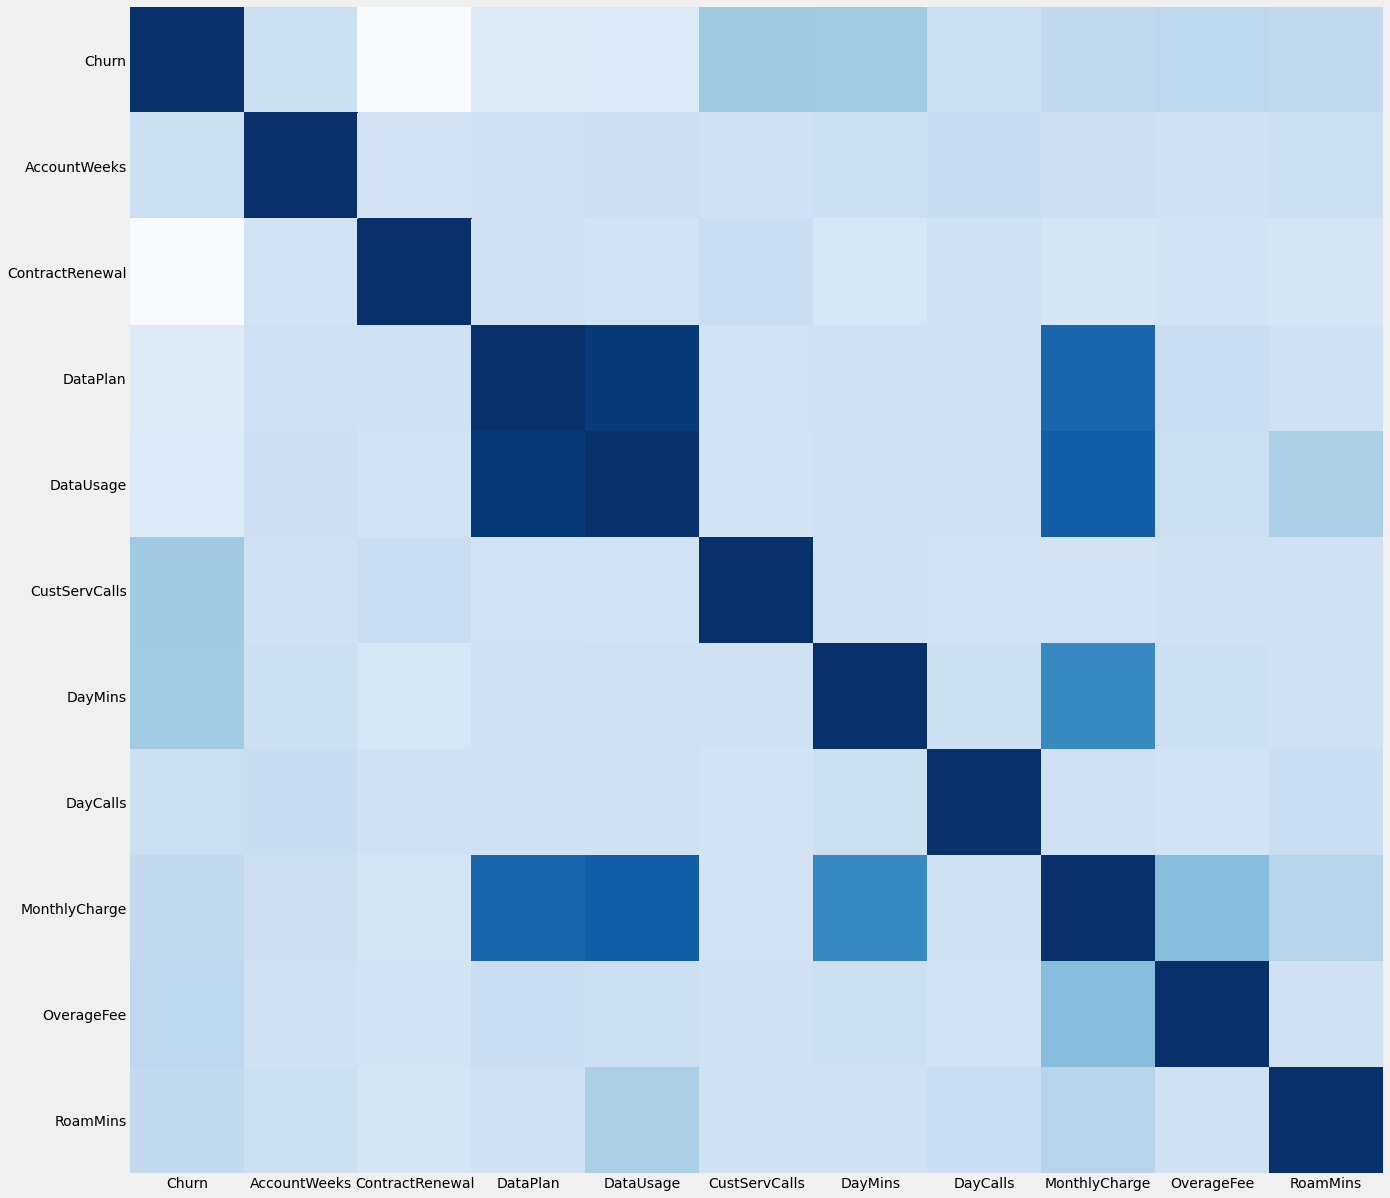

In [ ]:
plt.figure(figsize = (20, 20))
sb.heatmap(df.corr(), cbar = False, cmap = "Blues")
plt.show()

## 2.2 Questions and Hyphotesis
 
Here I will start a serious analysis to find out what makes customers to stop buying from the company.
 
### What are my hyphotesis?
 
I believe that DataPlan and ContractRenewal are the factors that most influence in the decision to stop buying from the company.
 
I will use data analysis to validate or refute it.
 
How will I do it? By analyzing a Pair plot, which shows the behaviour among all the variables.

### 2.2.1 Pair plot

It is possible to see that my hyphotesis was right. So what to do now we know it?

<Figure size 1440x1440 with 0 Axes>

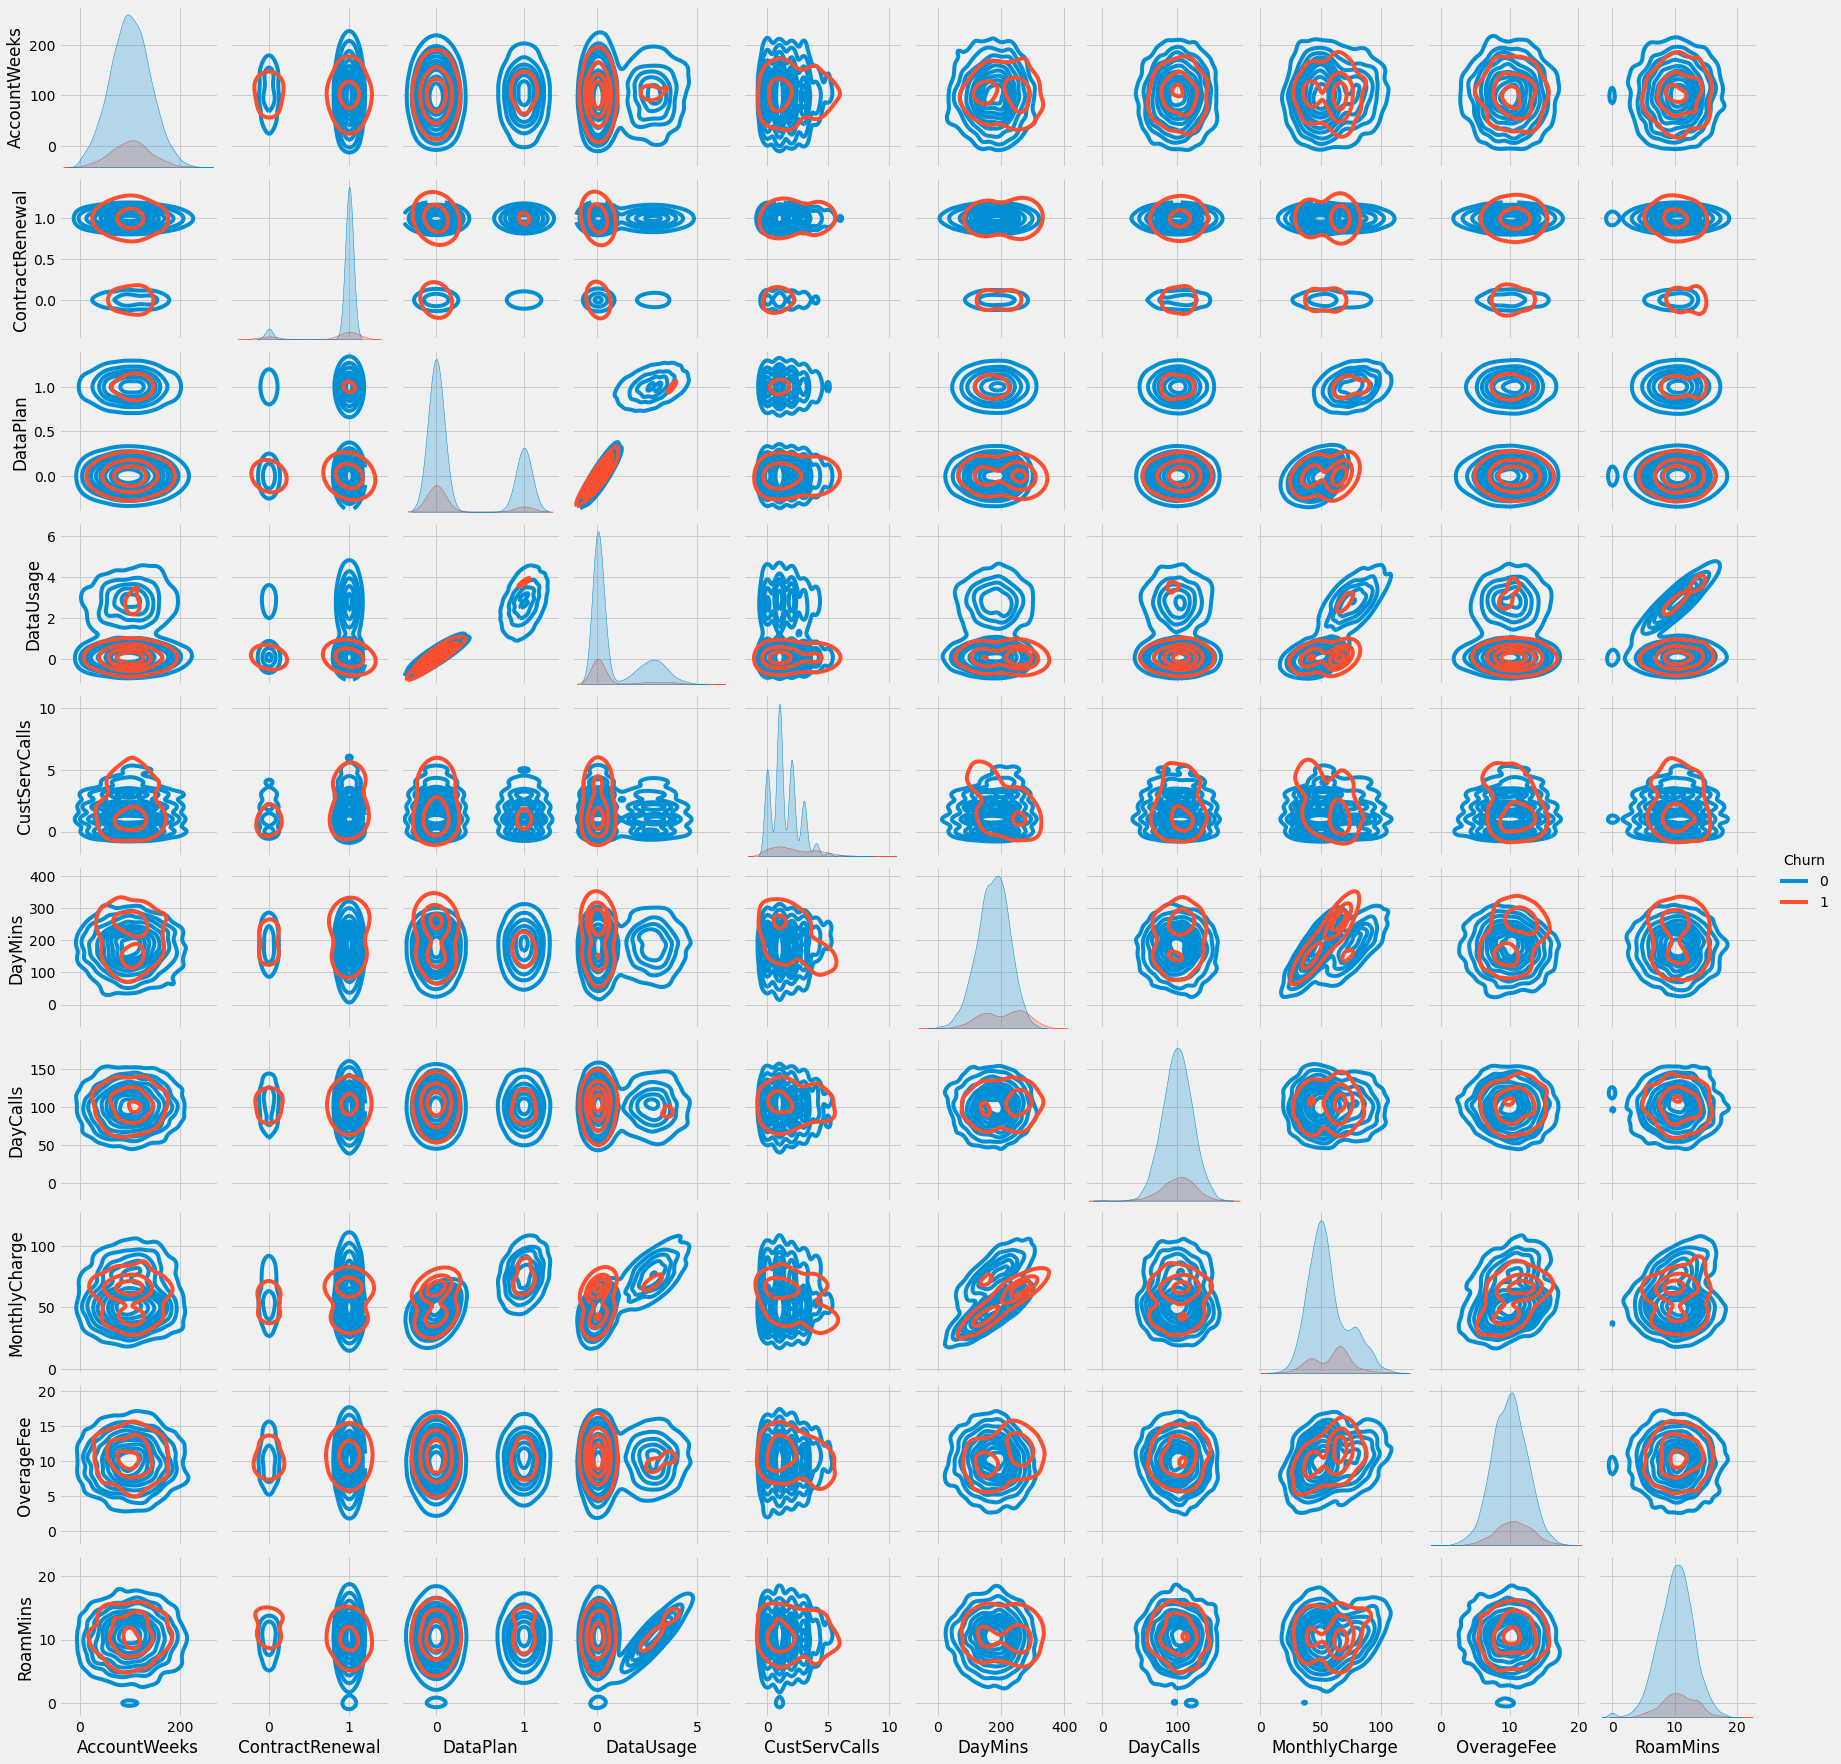

In [ ]:
plt.figure(figsize = (20, 20))
sb.pairplot(df, hue = "Churn", kind = "kde")
plt.show()

## 2.3 Conclusion
 
After the analysis I would recommend the company to try to sell more data plans and convince the customers to renew their contracts by offering special costs.

# 3.0 Machine Learning
 
Now we know what to do when a churn is detected we now need to find some how to predict churn. We can do it by building a Machine Learning model.

## 3.1 Separating features and the target
 
Target is the variable we want to predict and features are the variables the model uses to predict it.

In [ ]:
x, y = df.drop("Churn", axis = 1).copy(), df["Churn"].copy()

## 3.2 Normalization
 
Due the different variables' range it is necessary to normalize the data.

Normalization will apply a calculation that will turn all the variables' range into the same one (-1 to 1).
 
Obs: we only do it with the features

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x)
norm_x = scaler.transform(x)

## 3.3 Over Sampling 
 
Due the difference between the samples for Churns and Not churns it is necessary to generate new samples to balance.
 
What I do is generate new samples whose target is a Churn, data scientists call it Over Sampling.

In [ ]:
resampler = RandomOverSampler(random_state = 1)
new_x, new_y = resampler.fit_resample(norm_x, y)

### 3.3.1 Churn distribution after resampling

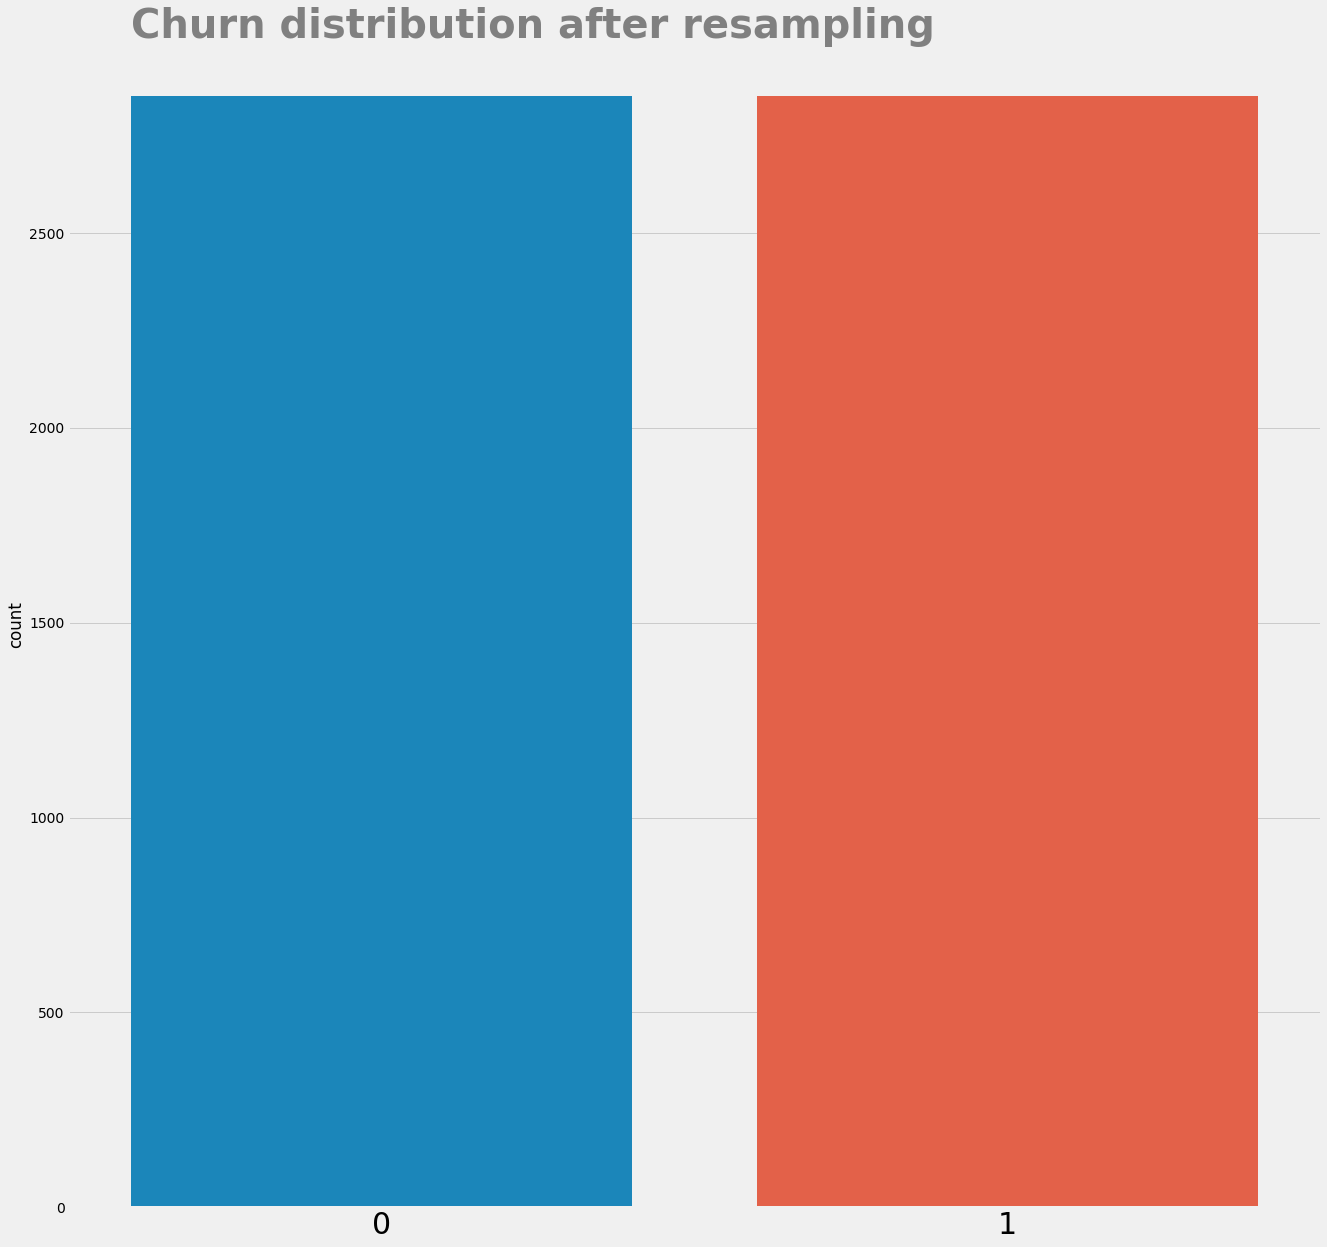

In [ ]:
plt.figure(figsize = (20, 20))
plt.text(s = "Churn distribution after resampling", x = -.4, y = 3000, fontsize = 40, weight = "bold", color = "gray")
sb.countplot(x = new_y)
plt.xticks(fontsize = 30)
plt.show()

## 3.4 Testing Algorithms
 
Here I will test several different algorithms to compare their performances and select the best one.
 
I will calculate the ROC-AUC for each model using Cross-Validation and plot every value returned by the model during the training process to visualize its variance.
 
**ROC-AUC**: it is a machine learning evaluation metric that tells how much the model is able to distinguish between the classes. The greater the better.
 
**Cross-Validation**: it is an evaluation method where the model is trained and tested in all parts of the dataset. By doing this we make sure the model is really what the metric tells.

### 3.4.x StratifiedKFold

In [ ]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

### 3.4.1 Logistic Regression

Mean:  0.8222566943674977


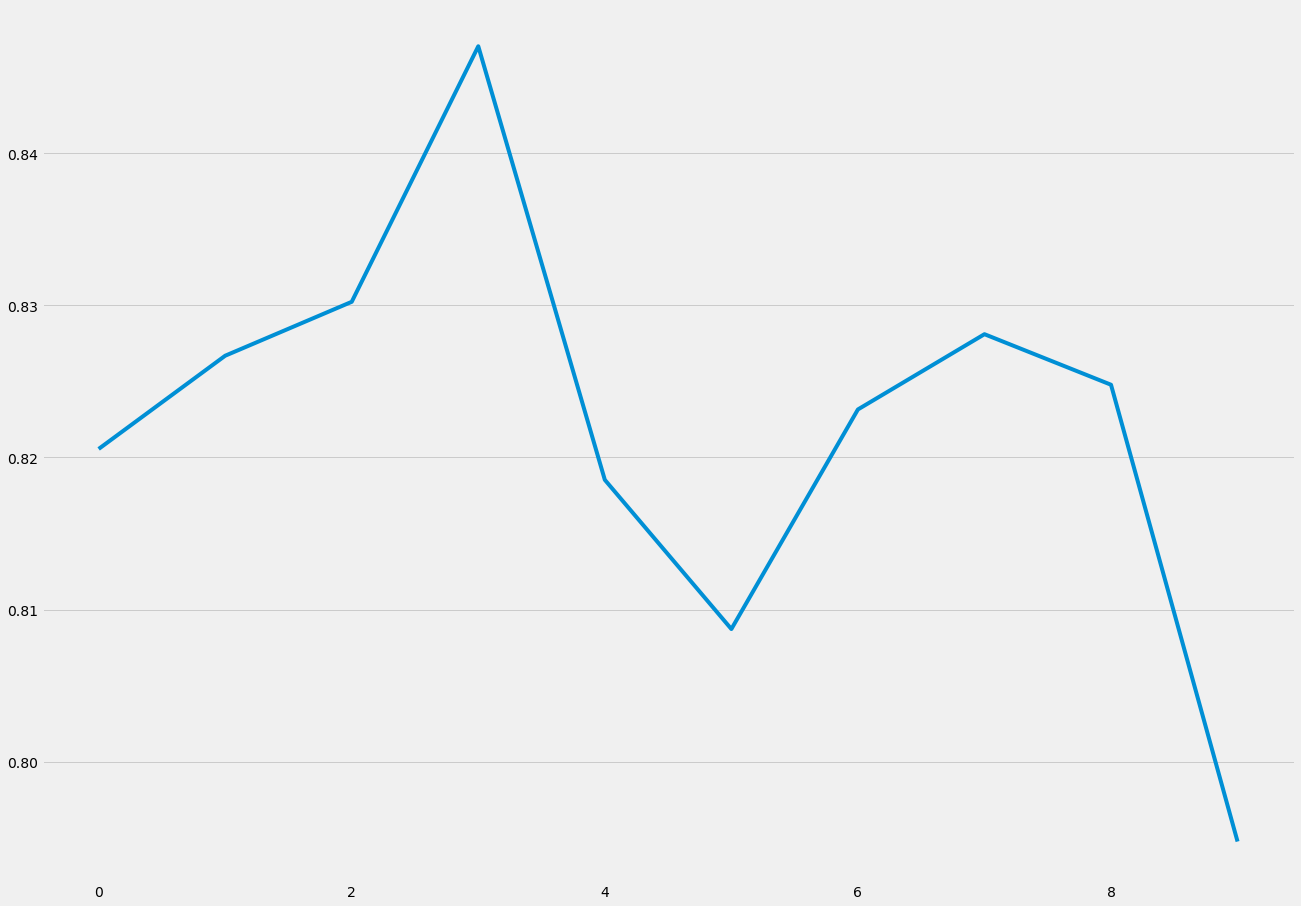

In [ ]:
lr = LogisticRegression(random_state = 1)
cross_val(lr)

### 3.4.2 Decision Tree

Mean:  0.9665287780855646


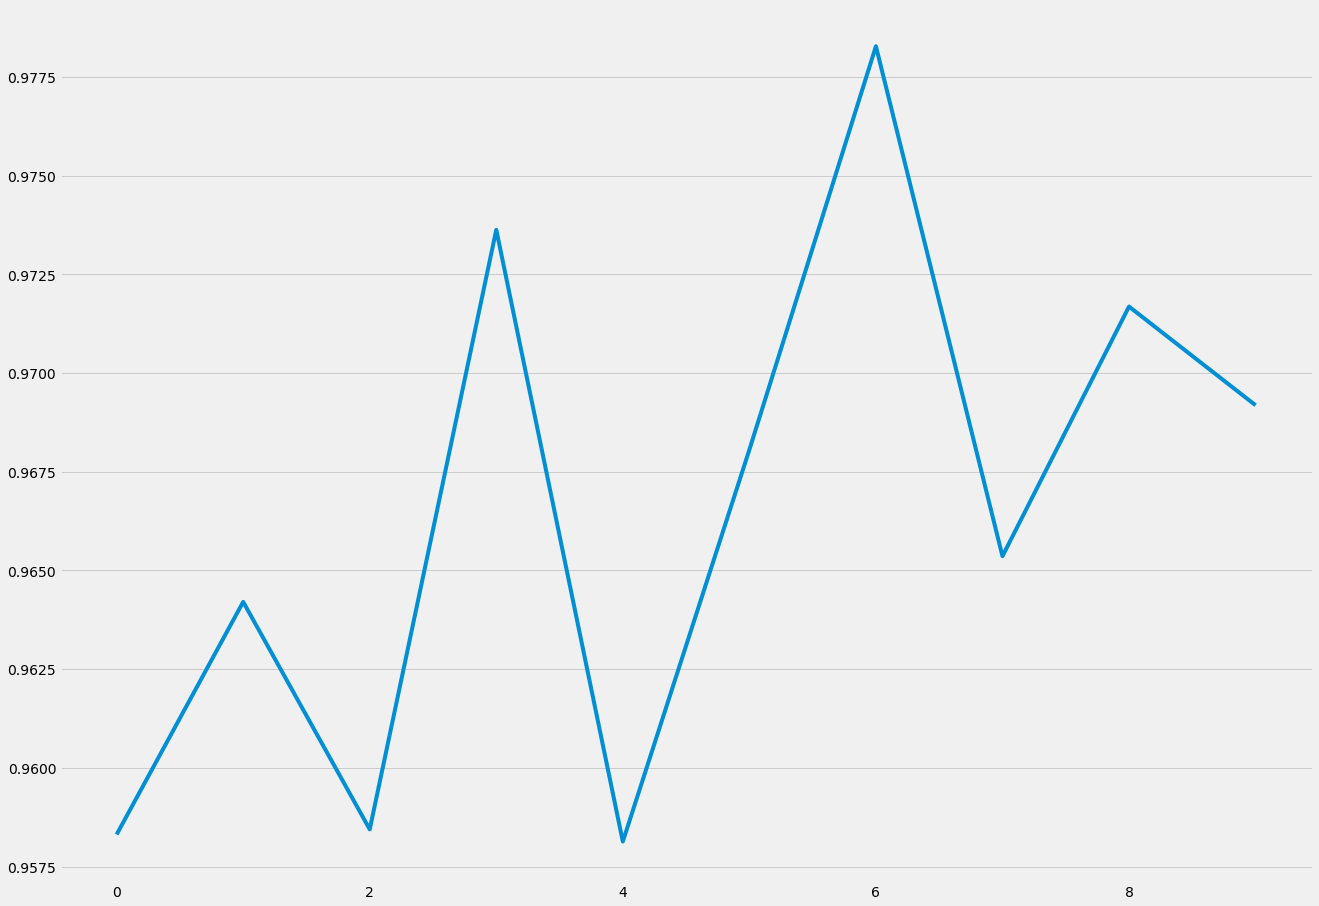

In [ ]:
dt = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 14, random_state = 1)
cross_val(dt)

### 3.4.3 Random Forest

Mean:  0.9997045244690673


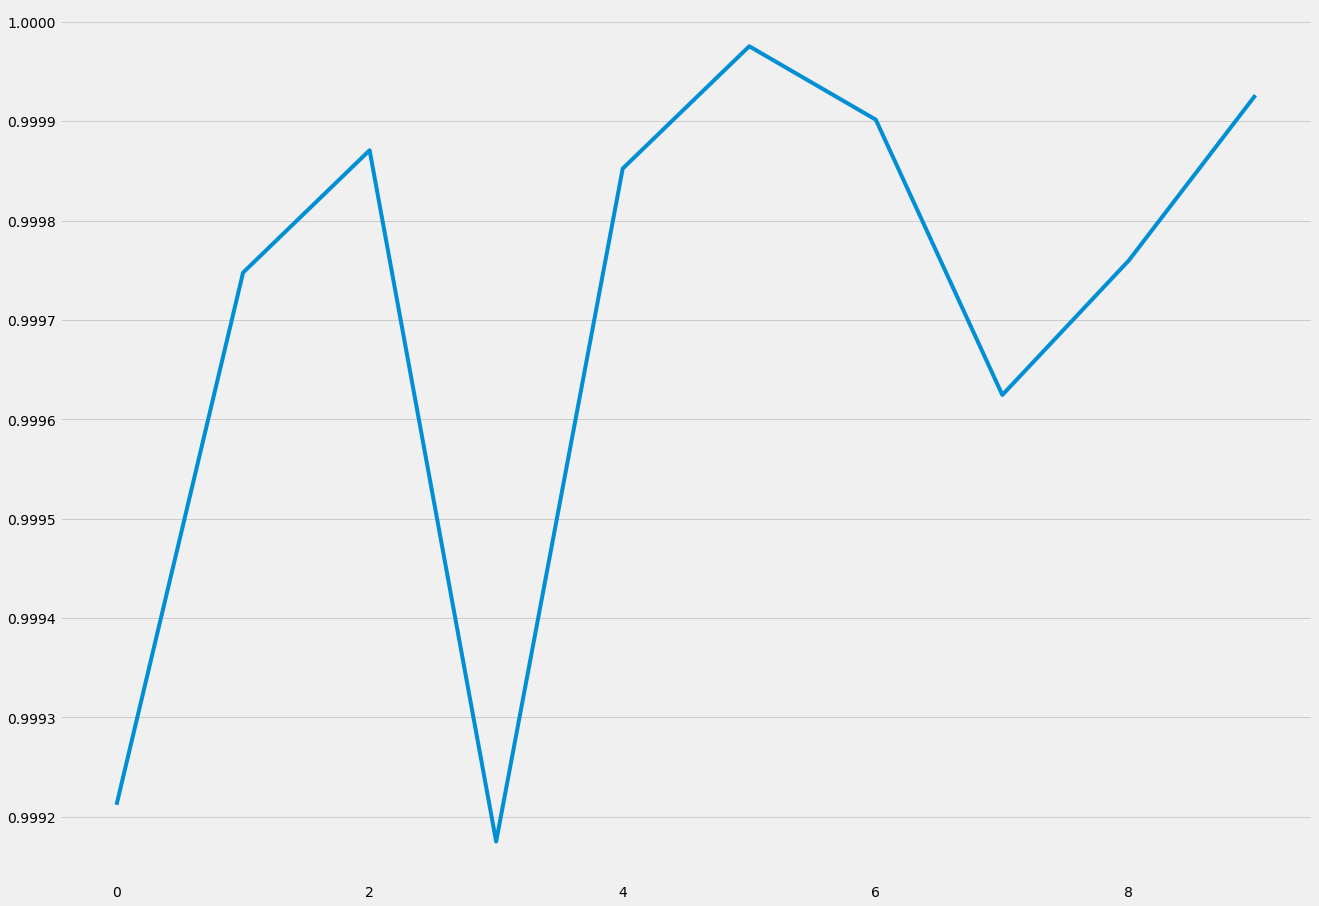

In [ ]:
rf = RandomForestClassifier(min_samples_leaf = 1, random_state = 1)
cross_val(rf)

### 3.4.4 LightGBM

Mean:  0.9950249307479225


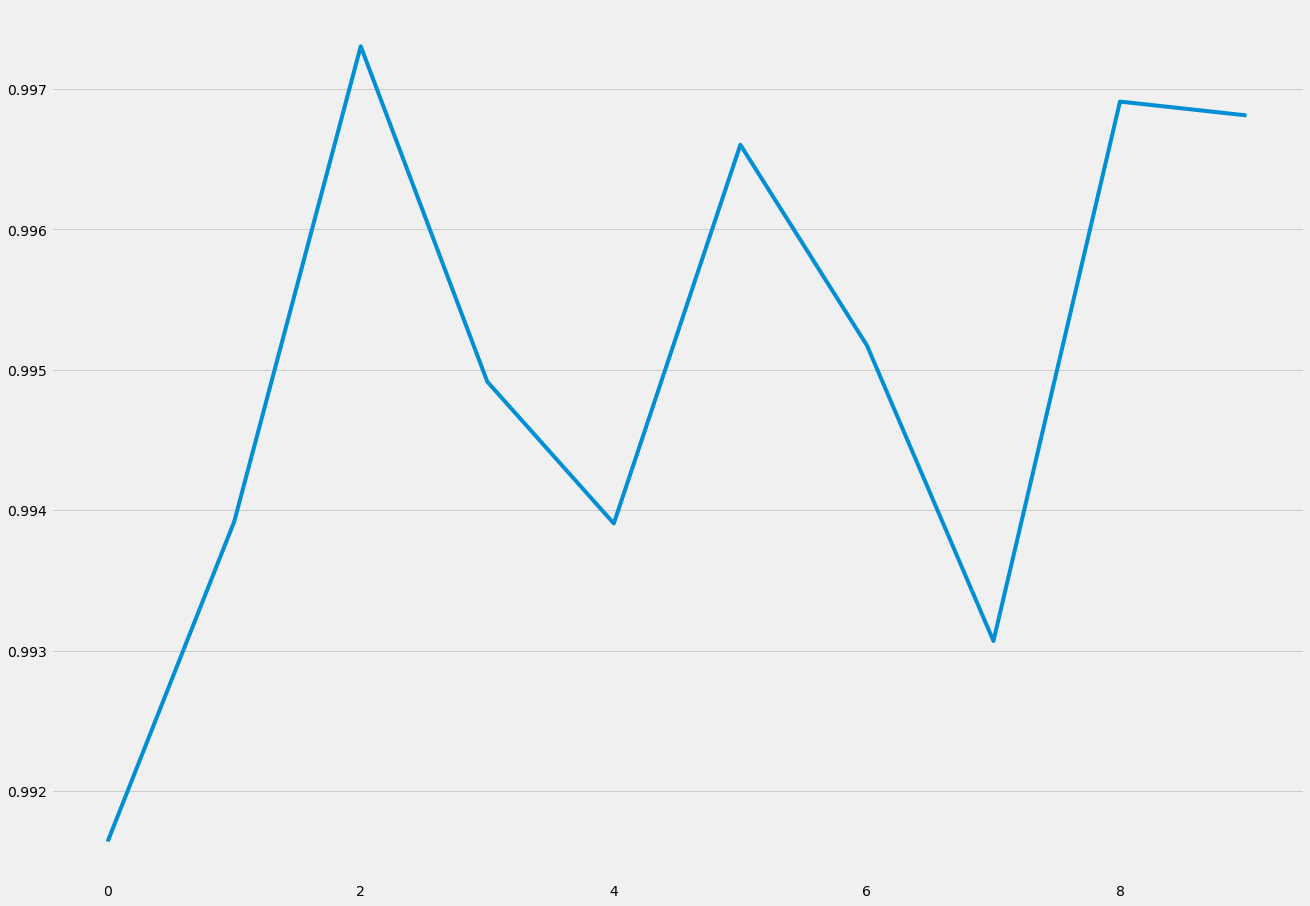

In [ ]:
lgbm = LGBMClassifier(min_samples_leaf = 1, random_state = 1)
cross_val(lgbm)

### 3.4.6 Conclusion
 
We can see that Random Forest's performance is the best one and it is the algorithm I will use.

## 3.5 Hyperparameters Tuning 
 
Every machine learning algorithm has parameters that can be changed to change the training process for many kind of datasets and to get different results.
 
Hyperparameters Tuning is the process to find the best parameters for the model.

In [ ]:
trainX, testX, trainY, testY = train_test_split(new_x, new_y, test_size = .5, random_state = 1)
 
space = [
(2, 25), # min_samples_split
(1, 15), # max_depth
(1, 15)  # min_samples_leaf
]
 
best_params = gp_minimize(train_model, space, random_state = 1, n_calls = 30, verbose = 1, n_random_starts = 10)

Iteration No: 1 started. Evaluating function at random point.
[25, 14, 3] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4417
Function value obtained: -0.9660
Current minimum: -0.9660
Iteration No: 2 started. Evaluating function at random point.
[25, 4, 7] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3420
Function value obtained: -0.9054
Current minimum: -0.9660
Iteration No: 3 started. Evaluating function at random point.
[11, 10, 14] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4417
Function value obtained: -0.9499
Current minimum: -0.9660
Iteration No: 4 started. Evaluating function at random point.
[21, 5, 8] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4429
Function value obtained: -0.9215
Current minimum: -0.9660
Iteration No: 5 started. Evaluating function at random point.
[12, 4, 8] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3450
Function value 

### 3.5.1 Training another model

Mean:  0.9989005847953217


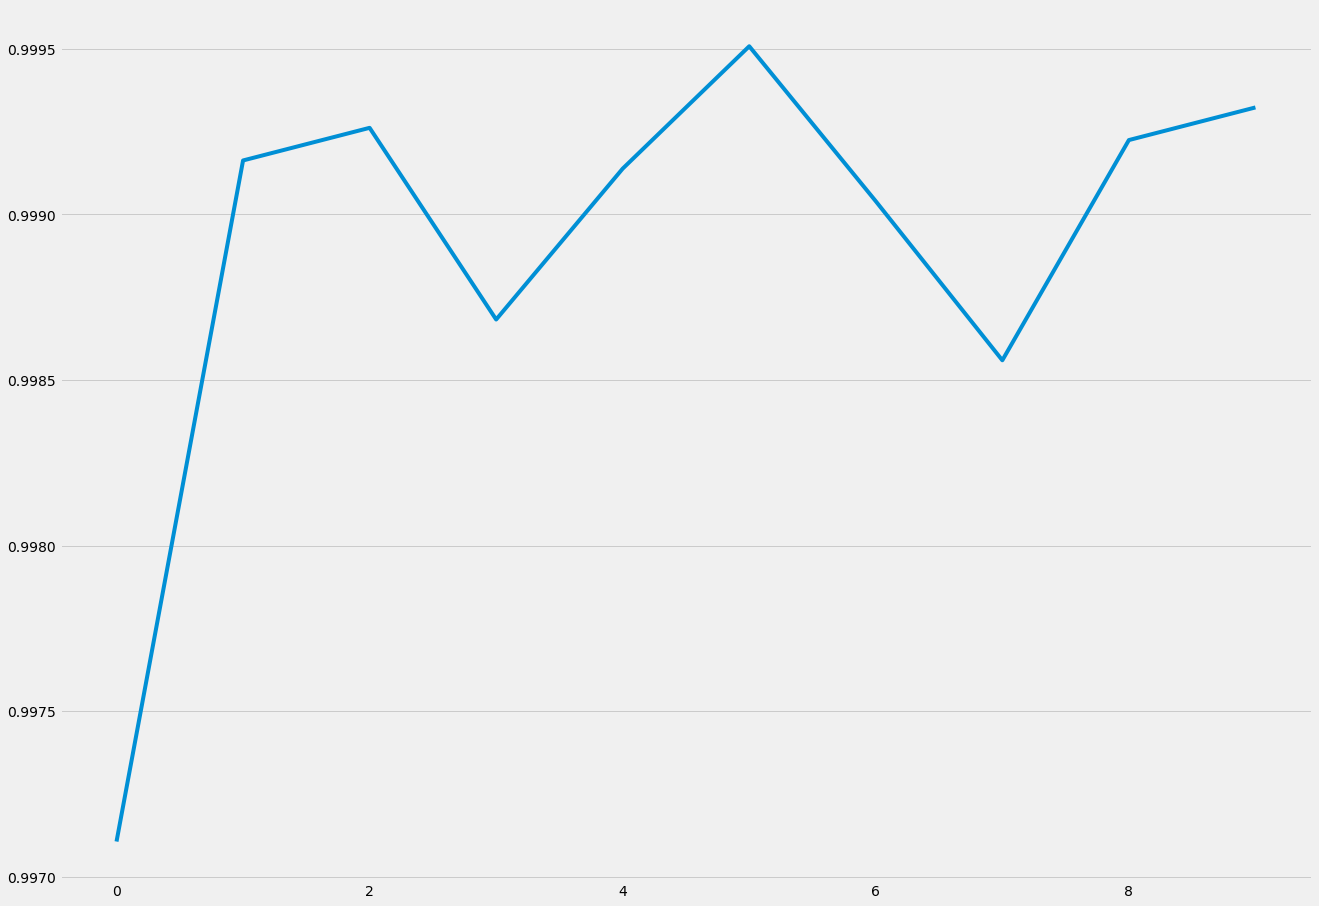

In [ ]:
rf2 = RandomForestClassifier(
min_samples_split = best_params.x[0],
max_depth = best_params.x[1],
min_samples_leaf = best_params.x[2],
random_state = 1,
n_jobs = -1,
n_estimators = 100
)
 
cross_val(rf2)

 
### 3.5.2 Conclusion
 
We can see that this model is not better than the common one, so I will use a simple version of the Random Forest algorithm for deployment.

 ## 3.6 Final Model
 
The final result is an almost perfect model with 99.97% of ROC-AUC.

Mean:  0.9997045244690673


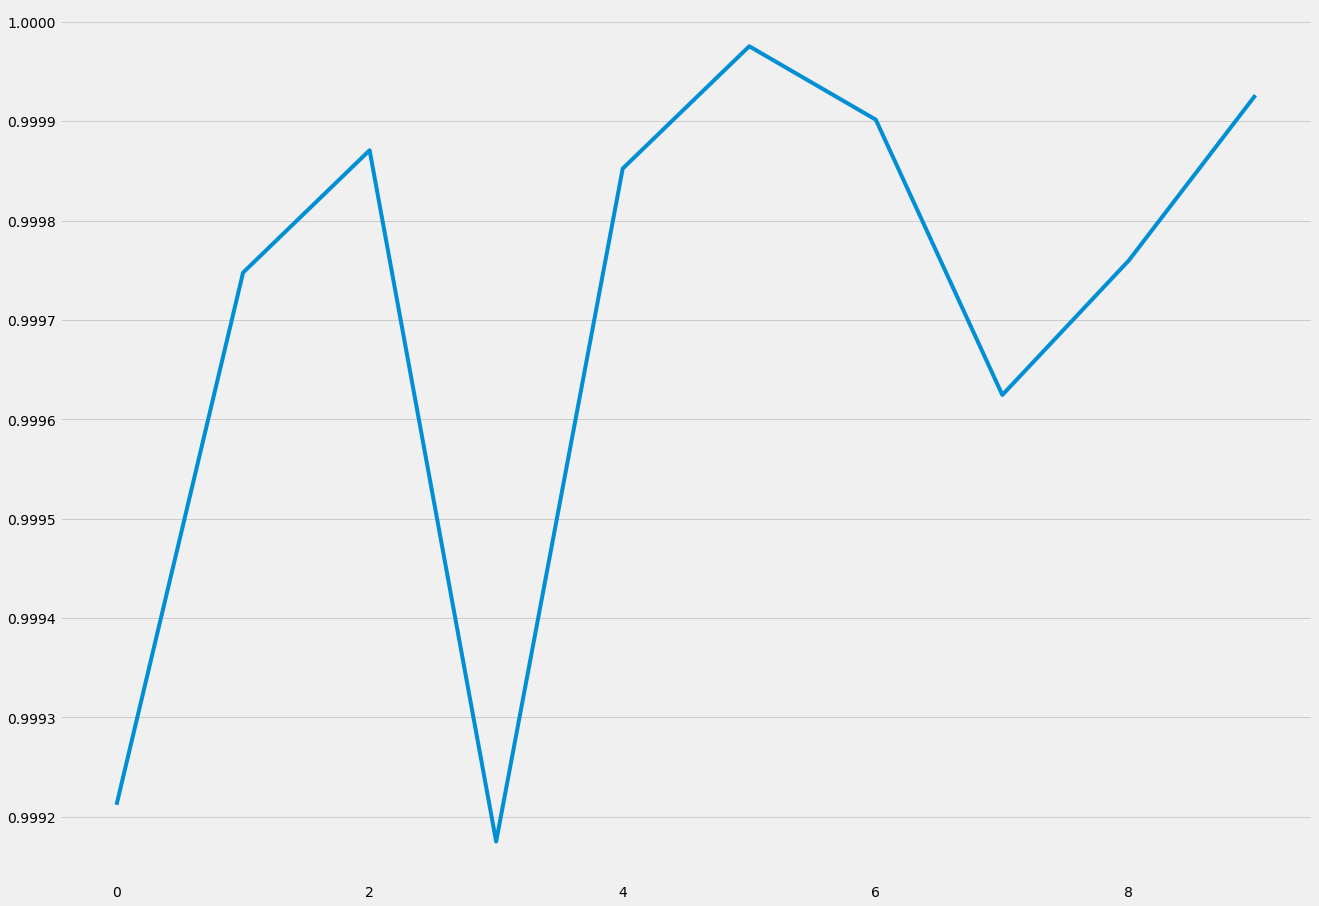

In [ ]:
model = rf
cross_val(model)

In [ ]:
model.fit(new_x, new_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

## 3.7 Feature Selection
 
It is now time to make some tests so see if there are features in the training process that are not so relevant for the model.
 
We do it by analyzing their importances.

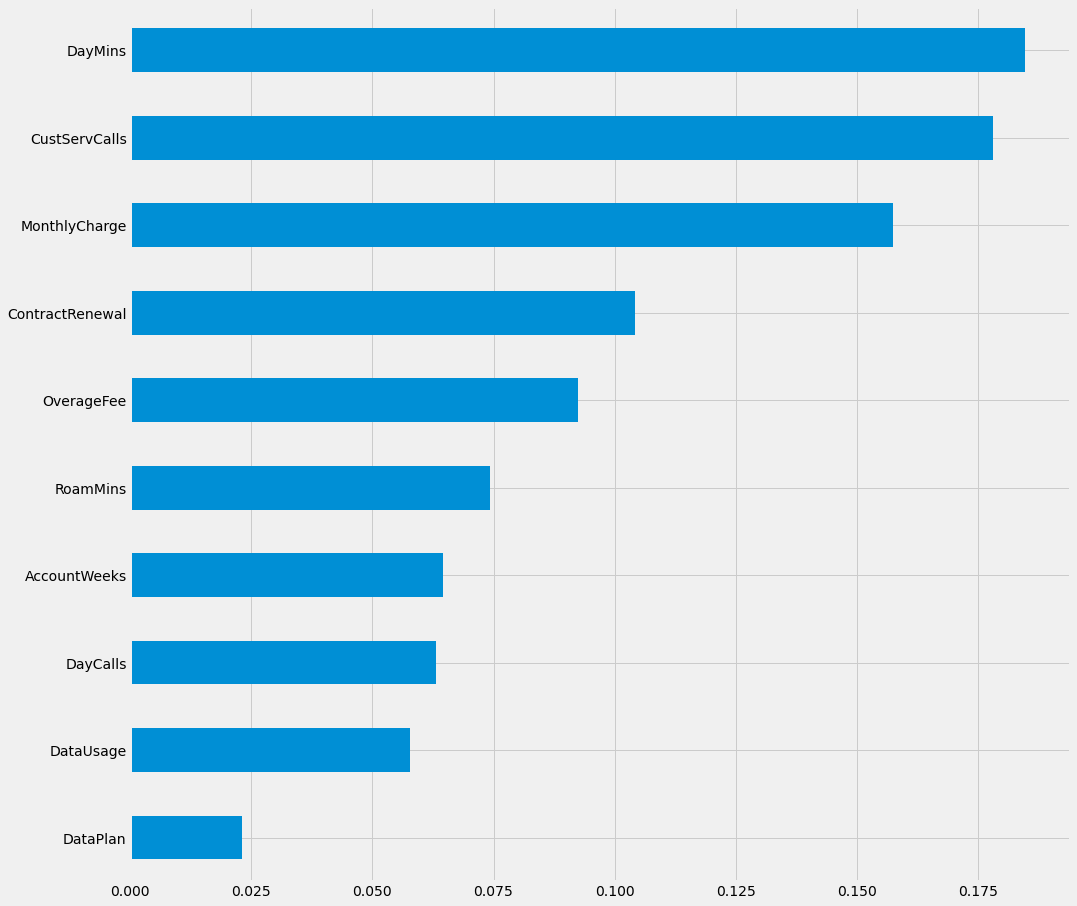

In [ ]:
features_importances(model, x.columns)

### 3.7.1 1st cycle

Mean:  0.9997045244690673


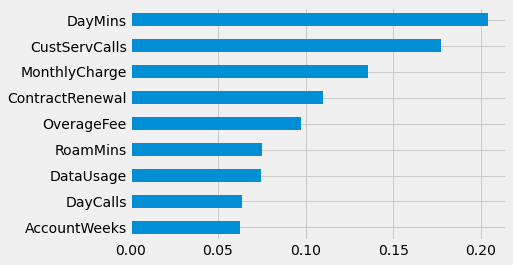

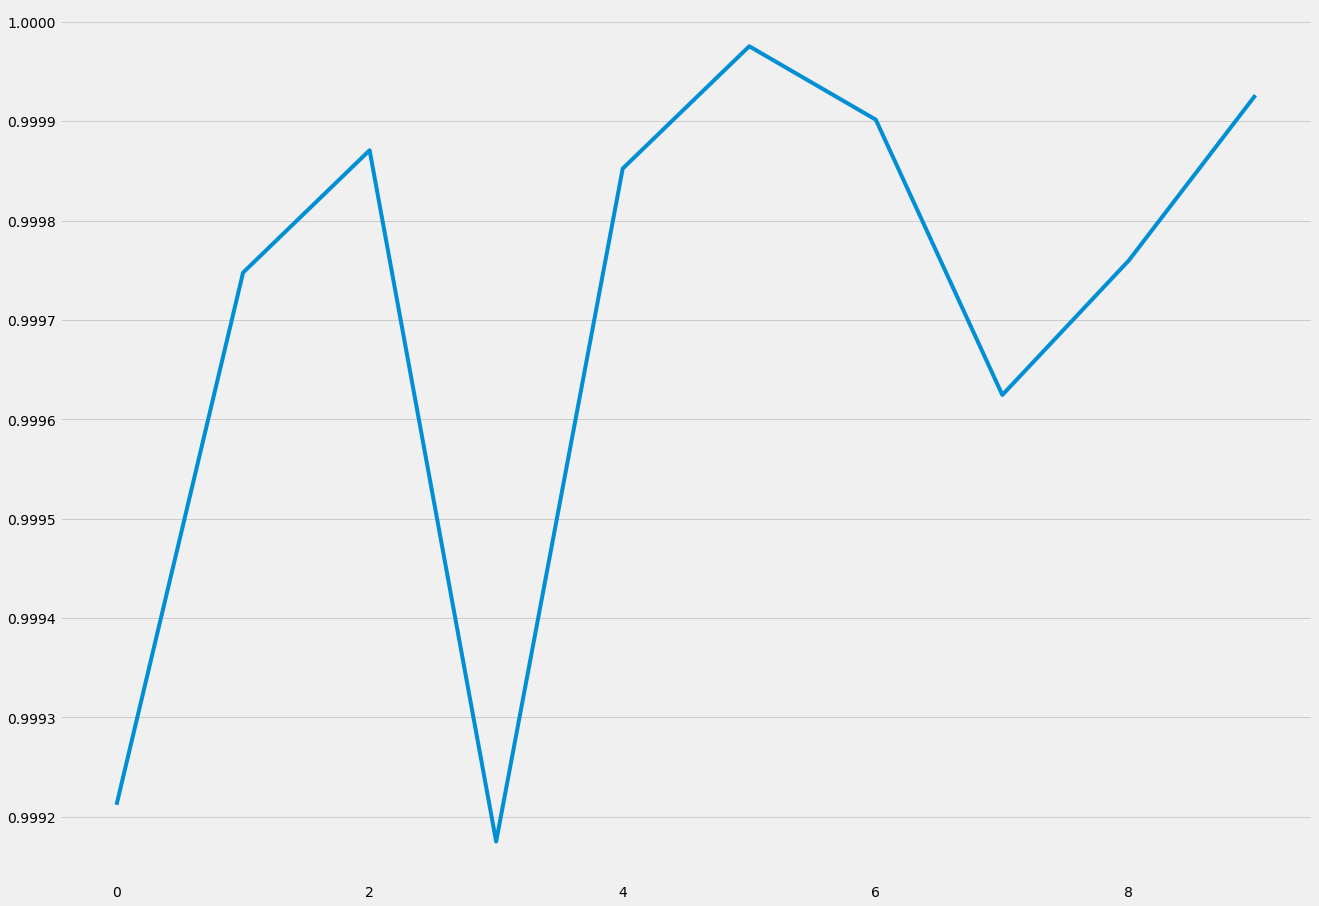

In [ ]:
model2 = cycle(to_drop = ["Churn", "DataPlan"])

### 3.7.2 2nd Cycle

Mean:  0.9997045244690673


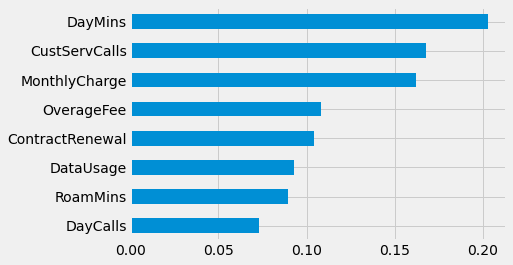

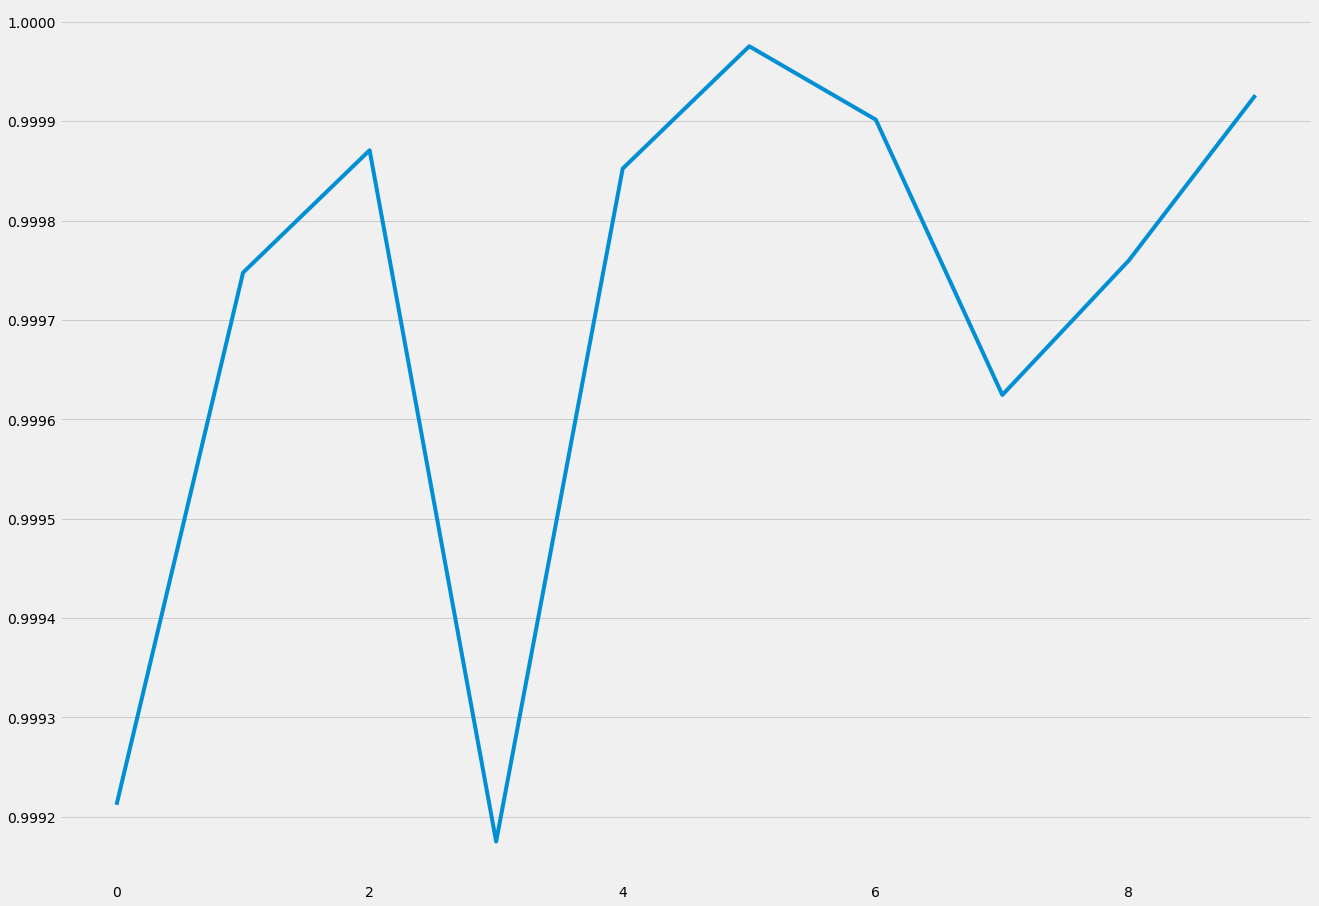

In [ ]:
model3 = cycle(to_drop = ["Churn", "DataPlan", "AccountWeeks"])

### 3.7.3 3th Cycle

Mean:  0.9997045244690673


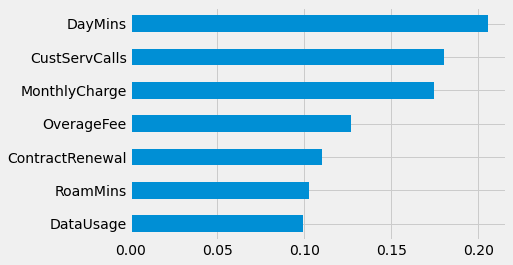

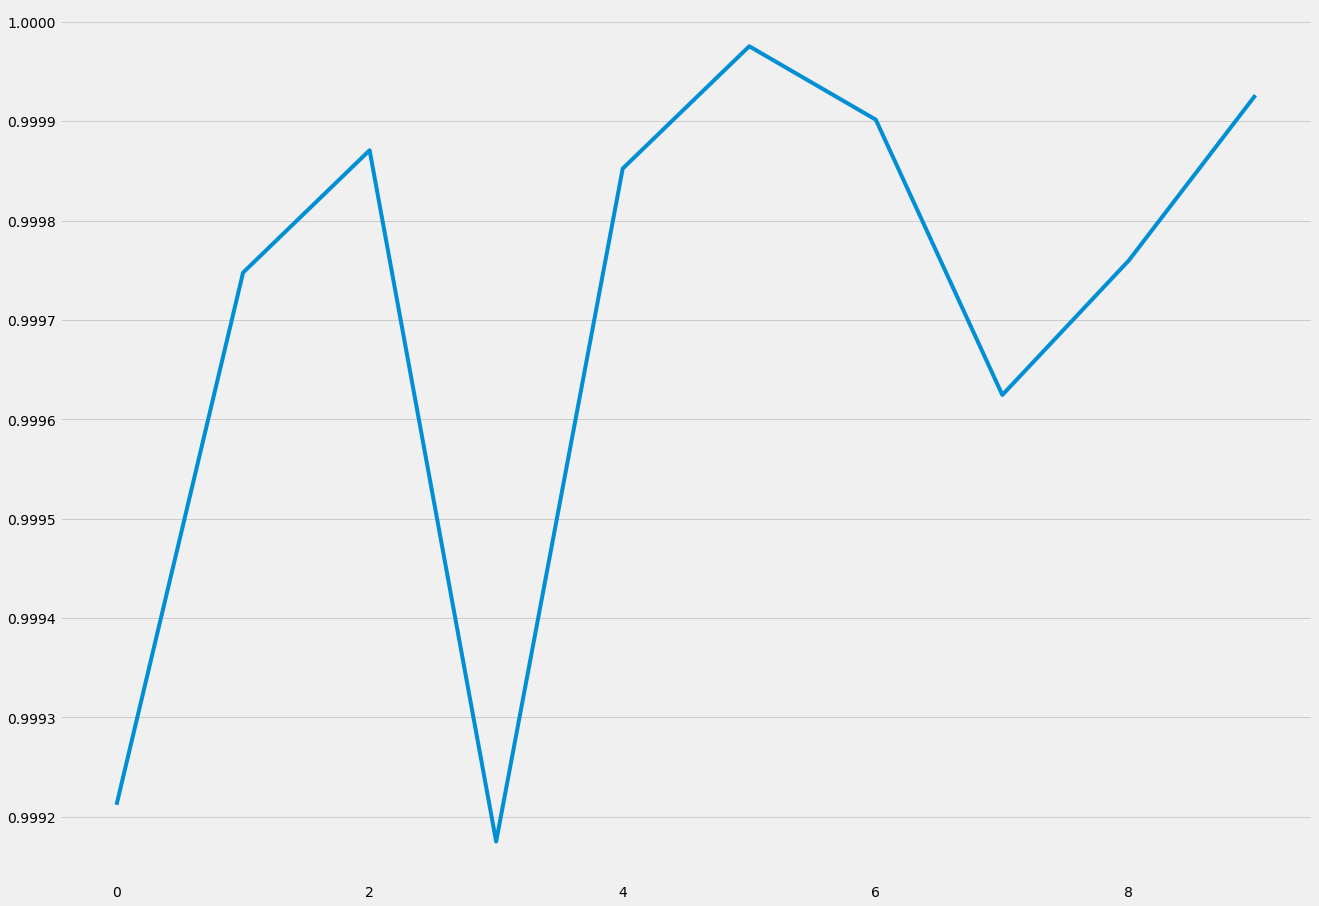

In [ ]:
model4 = cycle(to_drop = ["Churn", "DataPlan", "AccountWeeks", "DayCalls"])

### 3.7.4 Conclusion
 
It looks like that exclude variables will not improve the performance of the model. So, I will deploy the first one.

## 3.8 Saving the model

In [ ]:
filename = "model.pkl"
with open(filename, "wb") as file:
   pickle.dump(model, file)

 ## 3.8 Deployment
 
This model was deployed using a Web App built with Streamlit (a framework). This way external machines can access this solution and Tele Coastal can use this data science solution to prevent more churns from happening.
 
If you would like to access the site to make some tests you just need to access this link: https://bit.ly/2Q6xLnw

#**That's All**